<h1 style='text-align:center'>Generate CSV that Matches Bitcoin Price to Stock Market Hours <br><br></h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import requests, os


<h3>Go to <a href=http://www.cryptodatadownload.com/data/gemini/>http://www.cryptodatadownload.com/data/gemini/</a> and download yearly minute csv files. The download links are highlighted below. </h3>

<img>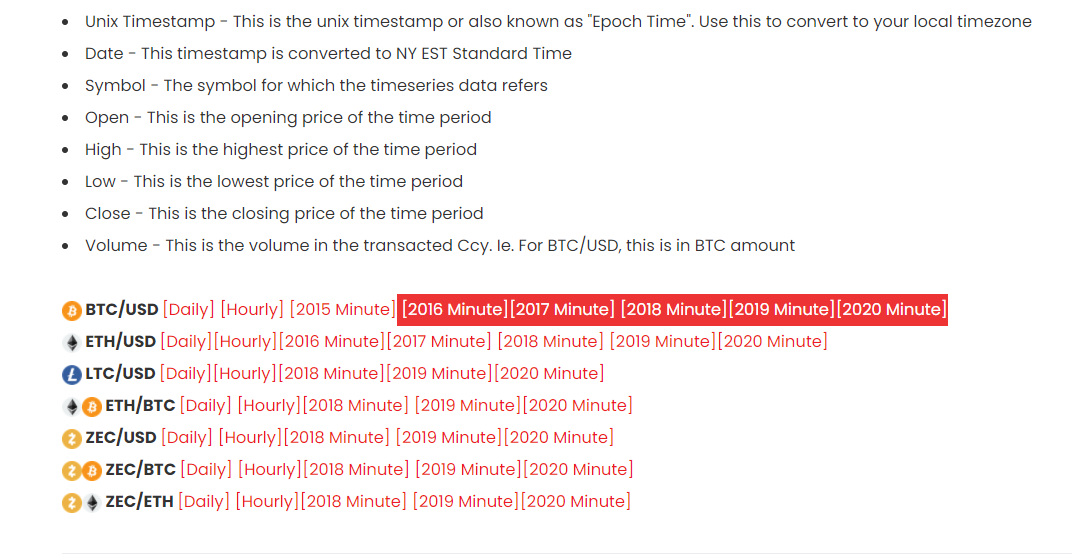</img>

<h4>Fill in your directory address and start date.</h4>

In [2]:
my_directory = '/Users/Ben/Desktop/coding_temple/final_project/'
start = '2016-01-01'

Get data from files and reduce it to only the open price for each minute (now only a measly 1 million data points per year)

In [3]:
df_btc = pd.DataFrame()
for filename in os.listdir(my_directory):
    if filename.startswith("gemini_BTCUSD"):
        get_df_btc = pd.read_csv(my_directory + filename)
        get_df_btc.drop(labels=[get_df_btc.columns[0],get_df_btc.columns[1]], axis=1, inplace=True)
        get_df_btc.reset_index(inplace=True)
        get_df_btc.drop(columns=['level_0', 'level_2', 'level_4', 'level_5'], axis=1, inplace=True)
        get_df_btc.rename(columns={"level_1":"date", 'level_3':'price'}, inplace=True)
        get_df_btc.drop([0], axis=0, inplace=True)
        df_btc = df_btc.append(get_df_btc)
        
df_btc = df_btc.sort_values(by=['date'])
df_btc.reset_index(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Get bitcoin price at 930am est each day (for days this data is missing I filled it in with the average of the day prior and the day after). This step will take a little while.

In [92]:
start_date = datetime.strptime(start, '%Y-%m-%d').date() 
days_num = (datetime.strptime(df_btc['date'][len(df_btc)-1][:10], '%Y-%m-%d').date() - 
            datetime.strptime(df_btc['date'][1][:10],'%Y-%m-%d').date()).days
df_open = pd.DataFrame()

for x in range(0,days_num+1):
    if len(df_btc.loc[df_btc['date']==str(start_date + timedelta(days=x)) + ' 09:30:00']) > 0:
        df_open = df_open.append(df_btc.loc[df_btc['date']==str(start_date + timedelta(days=x)) + ' 09:30:00'])
    else:
        for t in range(1,100):
            if len(df_btc.loc[df_btc['date']==str(start_date + timedelta(days=x+t)) + ' 09:30:00']) > 0:
                df_open.loc[x] = [x, str(start_date + timedelta(days=x)) + ' 09:30:00',
                float(df_open.loc[df_open['date']==str(start_date + timedelta(days=x-1)) + ' 09:30:00']['price']) + 
                (float(df_btc.loc[df_btc['date']==str(start_date + timedelta(days=x+t)) + ' 09:30:00']['price']) -
                float(df_open.loc[df_open['date']==str(start_date + timedelta(days=x-1)) + ' 09:30:00']['price']) )/(t+1)]
                break

df_open.rename(columns={"price":"open_price"}, inplace=True)
df_open.reset_index(inplace=True)
df_open.drop(columns=['level_0', 'index'], axis=1, inplace=True)
for x in range(len(df_open)):
    df_open['date'][x] = df_open['date'][x][:10]

Get bitcoin price at 4pm est each day (for days this data is missing I filled it in with the average of the day prior and the day after). This step will take a little while.

In [98]:
df_close = pd.DataFrame() 
for x in range(0,days_num+1):
    if len(df_btc.loc[df_btc['date']==str(start_date + timedelta(days=x)) + ' 16:00:00']) > 0:
        df_close = df_close.append(df_btc.loc[df_btc['date']==str(start_date + timedelta(days=x)) + ' 16:00:00'])
    else:
        for t in range(1,100):
            if len(df_btc.loc[df_btc['date']==str(start_date + timedelta(days=x+t)) + ' 16:00:00']) > 0:
                df_close.loc[x] = [x, str(start_date + timedelta(days=x)) + ' 16:00:00',
                float(df_close.loc[df_close['date']==str(start_date + timedelta(days=x-1)) + ' 16:00:00']['price']) + 
                (float(df_btc.loc[df_btc['date']==str(start_date + timedelta(days=x+t)) + ' 16:00:00']['price']) -
                float(df_close.loc[df_close['date']==str(start_date + timedelta(days=x-1)) + ' 16:00:00']['price']) )/(t+1)]
                break
df_close.rename(columns={"price":"close_price"}, inplace=True)
df_close.reset_index(inplace=True)
df_close.drop(columns=['level_0', 'index'], axis=1, inplace=True)
for x in range(len(df_close)):
    df_close['date'][x] = df_close['date'][x][:10]

Create final dataframe

In [100]:
df_open.set_index('date', inplace=True)
df_close.set_index('date', inplace=True)
df_stock_hrs = df_open
df_stock_hrs['close_price'] = df_close['close_price']
df_stock_hrs.reset_index(inplace=True)
df_stock_hrs

,date,open_price,close_price
0,2016-01-01,436.59,434.28
1,2016-01-02,433.19,436.72
2,2016-01-03,429,425.85
3,2016-01-04,429.98,432.92
4,2016-01-05,433.32,433.39
...,...,...,...
1851,2021-01-25,33248.44,34449.91
1852,2021-01-26,31620.13,31754.3
1853,2021-01-27,31020.89,30396.21
1854,2021-01-28,31274.48,31990.01


In [102]:
df_stock_hrs.to_csv('stock_hrs.csv', index=False)